In [4]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score

from sys import stdout

from helpers import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
ROOT_FOLDER = "../"
DATA_FOLDER = "data/processed/"

INPUT_LAB_SPEC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_train.csv"
INPUT_LAB_SPEC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_test.csv"

INPUT_LAB_CONC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_train.csv"
INPUT_LAB_CONC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_test.csv"

INPUT_AMB_SPEC = ROOT_FOLDER + DATA_FOLDER + "input_amb_spec.csv"
INPUT_AMB_CONC = ROOT_FOLDER + DATA_FOLDER + "input_amb_conc.csv"

# Loading the data

In [7]:
# Import Laboratory data

file_lab_spec_train = pd.read_csv(INPUT_LAB_SPEC_TRAIN, header=None)
file_lab_spec_test = pd.read_csv(INPUT_LAB_SPEC_TEST, header=None)
file_lab_conc_train = pd.read_csv(INPUT_LAB_CONC_TRAIN, header=None)
file_lab_conc_test = pd.read_csv(INPUT_LAB_CONC_TEST, header=None)

X_lab_train = pd.DataFrame(file_lab_spec_train).values.T
y_lab_train = pd.DataFrame(file_lab_conc_train).values.ravel()

X_lab_test = pd.DataFrame(file_lab_spec_test).values.T
y_lab_test = pd.DataFrame(file_lab_conc_test).values.ravel()

print("Train :\n")
print(X_lab_train.shape)
print(y_lab_train.shape)
print("\nTest :\n")
print(X_lab_test.shape)
print(y_lab_test.shape)

Train :

(144, 2784)
(144,)

Test :

(74, 2784)
(74,)


In [8]:
# Import Ambient data

file_amb_spec = pd.read_csv(INPUT_AMB_SPEC, header=None)
file_amb_conc = pd.read_csv(INPUT_AMB_CONC, header=None)

X_amb = pd.DataFrame(file_amb_spec).values.T
y_amb = pd.DataFrame(file_amb_conc).values.ravel()

print(X_amb.shape)
print(y_amb.shape)

(2230, 2784)
(2230,)


# Partial Least Squares

## Part I : Build model and use CV to determine optimal parameter and wavelengths

In [14]:
# Define PLS model using NIPALS algorithm
pls = PLSRegression(n_components=23, scale=False, tol=1e-6, max_iter=500)
pls.fit(X_lab_train, y_lab_train)

y_amb_predict = pls.predict(X_amb)
rmse_amb = np.sqrt(mean_squared_error(y_amb_predict, y_amb))
print(rmse_amb)

y_lab_predict = pls.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

13.279424794794053
0.7370432925347091


In [7]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X_lab_train[:,sorted_ind]

In [49]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((6,X.shape[1]))
    
    k = 0

    # Loop over the number of PLS components
    for i in range(19, 25, 1):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1, scale=False)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):

            pls2 = PLSRegression(n_components=i+1, scale=False)
            pls2.fit(Xc[:, j:], y)
            
            # Venetian blind cross-validation
            indices_venet = build_k_indices(y, nb_fold=5)
        
            score_cv = np.mean(cross_val_score(pls2, X[:,j:], y, cv=indices_venet,\
                                           scoring='neg_root_mean_squared_error'))

            mse[k,j] = -score_cv
        
        k=k+1
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx, mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+19)
    print("Wavelengths to be discarded ", mseminy[0])
    print('Optimised MSEP ', mse[mseminx, mseminy][0])
    stdout.write("\n")

    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1, scale=False)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [41]:
def simple_pls_cv(X_train, X_test, y_train, y_test, n_comp):

    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp, scale=False)
    pls.fit(X_train, y_train)
    y_predict = pls.predict(X_test).ravel()
    y_calibration = pls.predict(X_train)

    # Venetian blind cross-validation
    indices_venet = build_k_indices(y_train, nb_fold=5)
        
    score_cv = np.mean(cross_val_score(pls, X_train, y_train, cv=indices_venet, \
                                           scoring='neg_root_mean_squared_error'))

    # Calculate mean square error for calibration, cross validation and prediction
    rmse_c = np.sqrt(mean_squared_error(y_train, y_calibration))
    rmse_cv = -score_cv
    rmse_p = np.sqrt(mean_squared_error(y_test, y_predict))

    print('RMSE Calibration : ', rmse_c)
    print('RMSE CV: ', rmse_cv)
    print('RMSE Prediction : ', rmse_p)

    # Plot results
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_test, y_predict, c='red', edgecolors='k')
        ax.plot(y_test, y_test, color='black', linewidth=1)
        plt.xlabel('Reference value')
        plt.ylabel('Predicted value')
        plt.show()

In [50]:
opt_X_lab_train, ncomp, wav, sorted_ind = pls_variable_selection(X_lab_train, y_lab_train, 10)

250% completed
Optimised number of PLS components:  23
Wavelengths to be discarded  1052
Optimised MSEP  2.0807914300597027e-15



(74,) (144, 1)
RMSE Calibration :  1.0432164544494513
RMSE CV:  3.250867873538088e-15
RMSE Prediction :  19.301406713275735


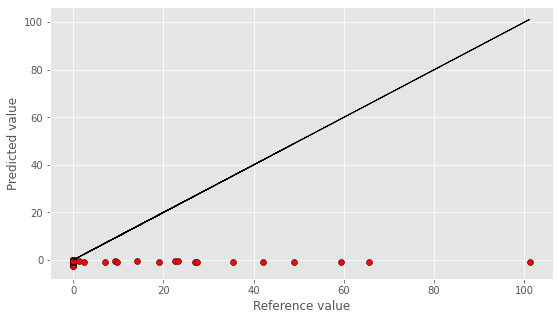

In [53]:
opt_X_lab_test = X_lab_test[:,wav:]
simple_pls_cv(opt_X_lab_train, opt_X_lab_test, y_lab_train, y_lab_test, ncomp)

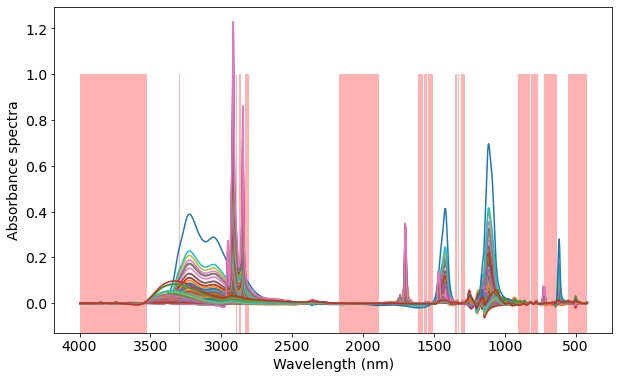

In [54]:
# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wn.ravel(), wn[sorted_ind][:wav])

import matplotlib.collections as collections

# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(10,6))
with plt.style.context(('ggplot')):
    ax.plot(wn, X_lab_train.T)
    ax.invert_xaxis()
    plt.ylabel('Absorbance spectra')
    plt.xlabel('Wavelength (nm)')

collection = collections.BrokenBarHCollection.span_where(
    wn, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)

plt.show()

## Part 2 : Train on laboratory samples and test on laboratory + ambient samples

In [11]:
# Define PLS model using NIPALS algorithm
pls = PLSRegression(n_components=23, scale=False, tol=1e-6, max_iter=500)
pls.fit(opt_X, y_lab_train)

#opt_X_amb = X_amb[:,wav:]
y_amb_predict = pls.predict(X_amb)
rmse_amb = np.sqrt(mean_squared_error(y_amb_predict, y_amb))
print(rmse_amb)

#opt_X_lab_test = X_lab_test[:,wav:]
y_lab_predict = pls.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

13.279424794794053
0.7370432925347091


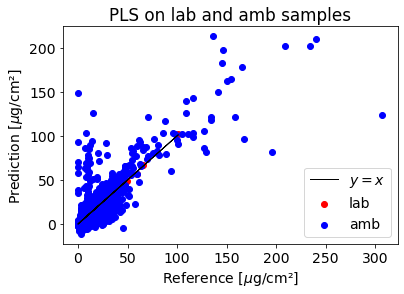

In [12]:
# Fit a line between reference and prediction

fig = plt.figure()
# z = np.polyfit(y_ref, y_pred, 1)
plt.scatter(y_lab_test, y_lab_predict, c='red', label='lab')
plt.scatter(y_amb, y_amb_predict, c='blue', label='amb')
#Plot the best fit line
# plt.plot(y_ref, np.polyval(z, y_ref), c='green', linewidth=1, label='fit')
plt.plot(y_lab_test, y_lab_test, color='black', linewidth=1, label='$y=x$') # line y = x 
plt.xlabel('Reference [$\mu$g/cm²]')
plt.ylabel('Prediction [$\mu$g/cm²]')
plt.legend()
plt.title('PLS on lab and amb samples')
plt.show()

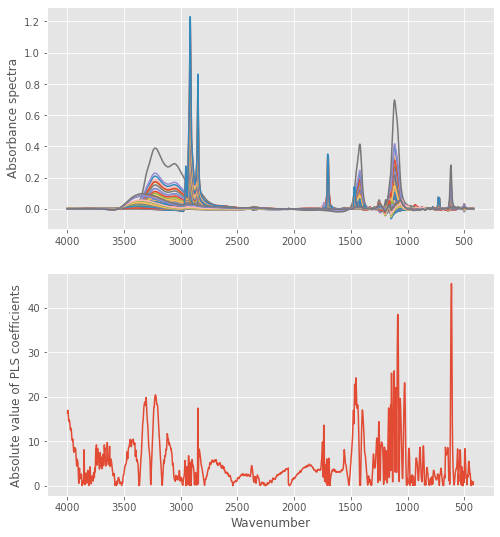

In [13]:
# These are the regression coefficients that quantify the strength of 
# the association between each wavelength and the response. 

# Define wavelength range
wn = np.linspace(3998,420,2784)

# Plot spectra
fig = plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wn, X_lab_train.T)
    ax1.invert_xaxis()
    plt.ylabel('Absorbance spectra')
    
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wn, np.abs(pls.coef_[:,0]))
    plt.xlabel('Wavenumber')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()

In [ ]:
fig.savefig('model_fits.png', dpi=100, bbox_inches = "tight")